In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd

# folder_path = 'C:/Users/quiet/Documents/jupyter/CS240/UNSW-NB15'
folder_path = '/content/drive/MyDrive/CS240/UNSW-NB15'


files = os.listdir(folder_path)

train_file = 'UNSW_NB15_training-set.csv'
test_file = 'UNSW_NB15_testing-set.csv'
train_path = os.path.join(folder_path, train_file)
test_path = os.path.join(folder_path, test_file)


data_train = pd.read_csv(train_path)
data_test = pd.read_csv(test_path)

print("Length of training set: ", len(data_train))
print("Length of testing set: ", len(data_test))

Length of training set:  82332
Length of testing set:  175341


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import string

import os

In [5]:
df = pd.concat([data_train, data_test])

In [6]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


1    0.639077
0    0.360923
Name: label, dtype: float64

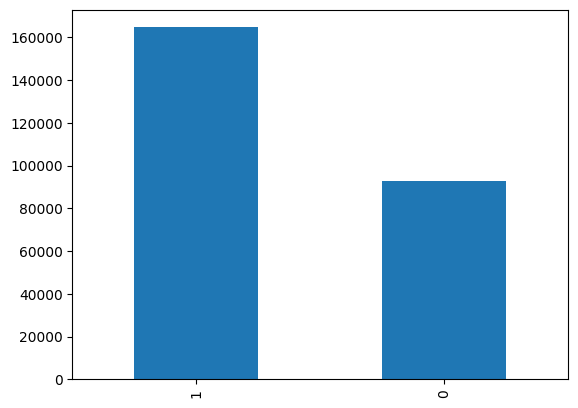

In [7]:
df['label'].value_counts().plot.bar()
df['label'].value_counts(normalize=True)

In [8]:
df['label'].value_counts(normalize=True)

1    0.639077
0    0.360923
Name: label, dtype: float64

In [9]:
df_cat = df.select_dtypes(exclude=[np.number])
print(df_cat.columns)
for feature in df_cat.columns:
    df[feature] = LabelEncoder().fit_transform(df[feature])

Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')


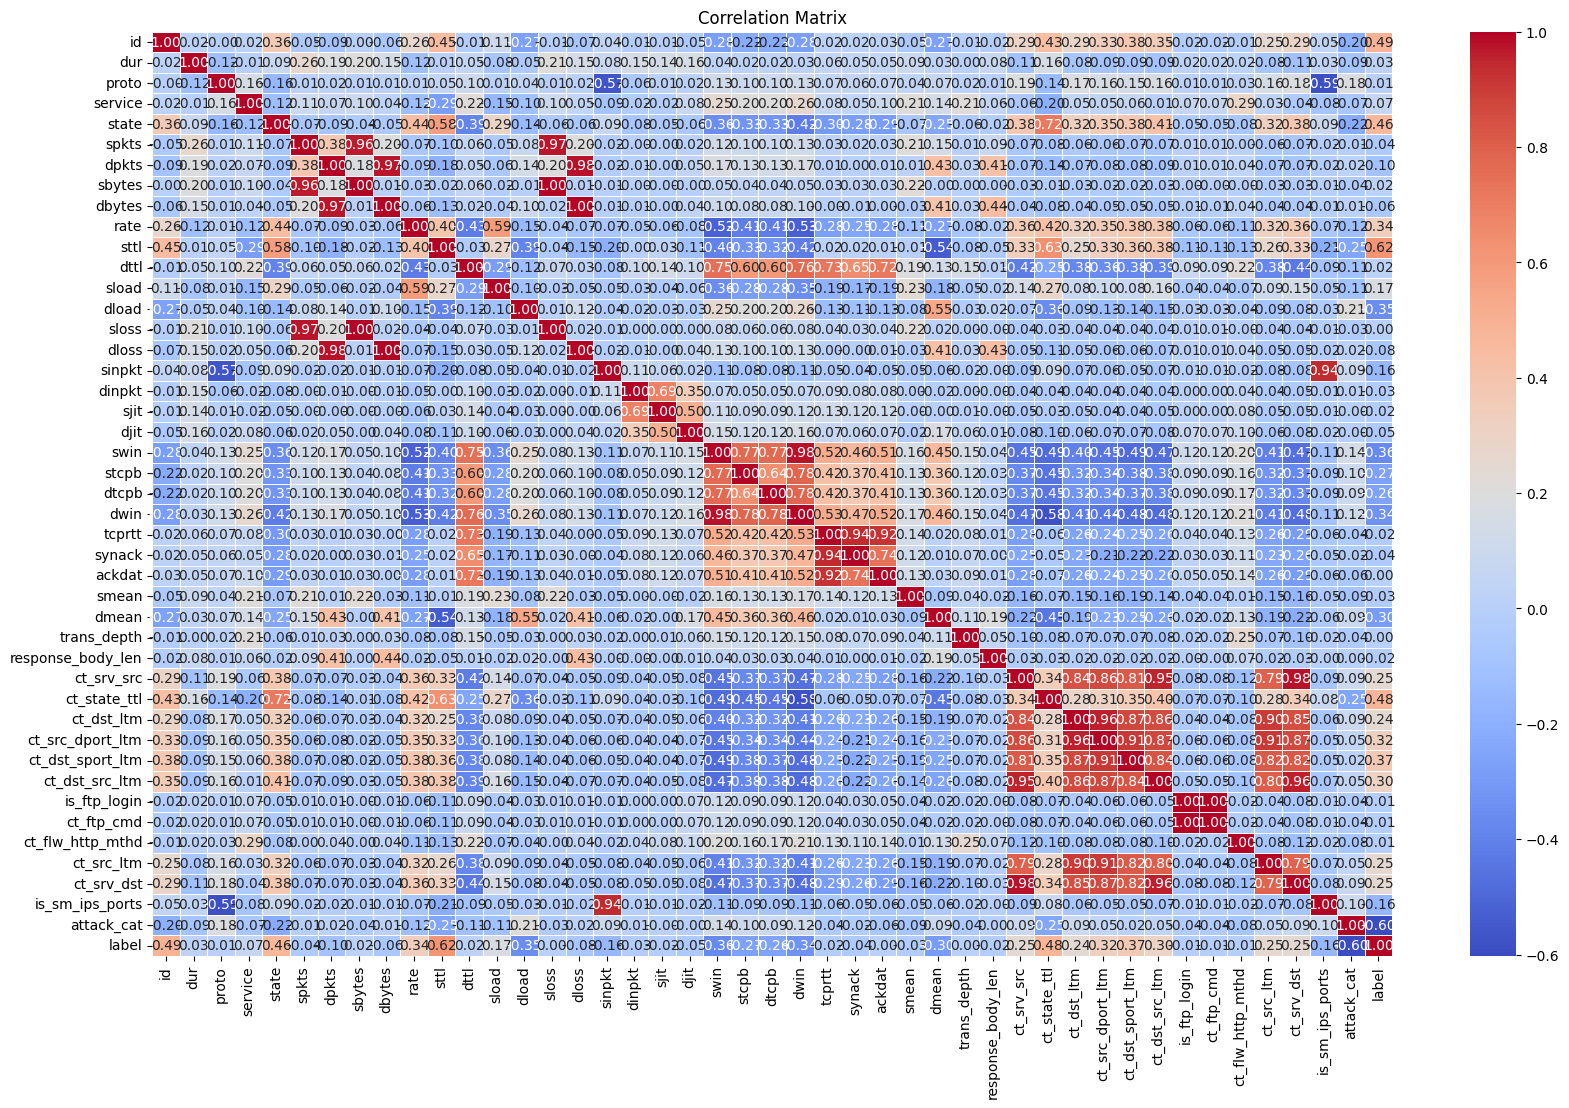

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming corr_matrix is your correlation matrix
plt.figure(figsize=(20, 12))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()


In [11]:
import numpy as np

# Set the threshold for correlation
threshold = 0.97

# Find the highly correlated variables
correlated_vars = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            correlated_vars.add((colname_j))
            print(f"Correlation between {colname_i} and {colname_j}: {corr_matrix.iloc[i, j]}")

# Print the number of highly correlated pairs
print("Number of highly correlated pairs:", len(correlated_vars))
print(correlated_vars)

Correlation between spkts and sloss: 0.9718594116511157
Correlation between dpkts and dbytes: 0.9734453279792993
Correlation between dpkts and dloss: 0.9796120849360007
Correlation between sbytes and sloss: 0.995771577240686
Correlation between dbytes and dloss: 0.9967111338314709
Correlation between swin and dwin: 0.9804584289136614
Correlation between ct_srv_src and ct_srv_dst: 0.9794668130725328
Correlation between is_ftp_login and ct_ftp_cmd: 0.9988554882935945
Number of highly correlated pairs: 6
{'dbytes', 'sloss', 'dloss', 'dwin', 'ct_srv_dst', 'ct_ftp_cmd'}


In [12]:
df = df.drop(columns=correlated_vars)
fruitydf = df.sample(n=1000, random_state=42)

In [13]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,attack_cat,label
0,1,0.000011,119,0,5,2,0,496,90909.0902,254,...,1,1,1,2,0,0,1,0,6,0
1,2,0.000008,119,0,5,2,0,1762,125000.0003,254,...,1,1,1,2,0,0,1,0,6,0
2,3,0.000005,119,0,5,2,0,1068,200000.0051,254,...,1,1,1,3,0,0,1,0,6,0
3,4,0.000006,119,0,5,2,0,900,166666.6608,254,...,2,2,1,3,0,0,2,0,6,0
4,5,0.000010,119,0,5,2,0,2126,100000.0025,254,...,2,2,1,3,0,0,2,0,6,0


In [14]:
X = df.drop(columns=['id', 'attack_cat', 'label'])
feature_list = list(X.columns)
X = np.array(X)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [15]:
print("Training set:", len(X_train))
print("Testing set:", len(X_test))

Training set: 206138
Testing set: 51535


In [16]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.optim.lr_scheduler as lr_scheduler

# Define your neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 15)
        self.fc4 = nn.Linear(15, 5)
        self.fc5 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
# Define input dimension
input_dim = X_train.shape[1]
batch_size = 64
epochs = 50


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to GPU
model = NeuralNetwork(input_dim).to(device)

# Convert your data to PyTorch tensors and move to GPU
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters())
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Define your dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Train your model
total_batches = len(train_loader)
# Define early stopping parameters
early_stopping_rounds = 5
best_val_loss = float('inf')
best_epoch = 0
early_stopping_counter = 0

In [ ]:
# Train your model
print("Using device: ", device)
for epoch in range(epochs):
    running_loss = 0.0
    val_loss = 0.0
    with tqdm(total=total_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss / (i+1)})
            pbar.update(1)

        # Calculate validation loss
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            val_loss = criterion(test_outputs, y_test_tensor)
            print(f"Train loss: {running_loss/(i+1)} Validation loss : {val_loss}")
            scheduler.step(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_rounds:
                print(f'Early stopping triggered! No improvement in validation loss for {early_stopping_rounds} consecutive epochs.')
                break

print('Training completed!')

# Evaluate your model
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)
    train_acc = (train_outputs.argmax(dim=1) == y_train_tensor).float().mean()

    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_acc = (test_outputs.argmax(dim=1) == y_test_tensor).float().mean()

print(f'Train: Loss: {train_loss.item()}, Accuracy: {train_acc.item()}')
print(f'Validation: Loss: {test_loss.item()}, Accuracy: {test_acc.item()}')
print(f'Best Validation Loss: {best_val_loss.item()} at Epoch {best_epoch+1}')


Using device:  cuda


Epoch 1/50: 100%|███████████████████████████████████████████████████| 3221/3221 [00:39<00:00, 81.09batch/s, loss=0.188]


Train loss: 0.18824672630390407 Validation loss : 0.1568147838115692


Epoch 2/50: 100%|███████████████████████████████████████████████████| 3221/3221 [00:40<00:00, 79.15batch/s, loss=0.153]


Train loss: 0.1532078028241047 Validation loss : 0.15190419554710388


Epoch 3/50: 100%|███████████████████████████████████████████████████| 3221/3221 [00:40<00:00, 79.73batch/s, loss=0.146]


Train loss: 0.14642682154563152 Validation loss : 0.13991890847682953


Epoch 4/50: 100%|███████████████████████████████████████████████████| 3221/3221 [00:38<00:00, 82.98batch/s, loss=0.143]


Train loss: 0.1431310124804018 Validation loss : 0.13917657732963562


Epoch 5/50: 100%|███████████████████████████████████████████████████| 3221/3221 [00:40<00:00, 80.01batch/s, loss=0.141]


Train loss: 0.14062370625097573 Validation loss : 0.1361396312713623


Epoch 6/50: 100%|███████████████████████████████████████████████████| 3221/3221 [00:40<00:00, 79.48batch/s, loss=0.139]


Train loss: 0.13878044243919316 Validation loss : 0.13401103019714355


Epoch 7/50: 100%|███████████████████████████████████████████████████| 3221/3221 [00:39<00:00, 81.08batch/s, loss=0.138]


Train loss: 0.13781825413257207 Validation loss : 0.13607200980186462


Epoch 8/50: 100%|███████████████████████████████████████████████████| 3221/3221 [00:38<00:00, 84.24batch/s, loss=0.136]


Train loss: 0.1362788719511095 Validation loss : 0.13220779597759247


Epoch 9/50: 100%|███████████████████████████████████████████████████| 3221/3221 [00:38<00:00, 82.77batch/s, loss=0.135]


Train loss: 0.13543042050716772 Validation loss : 0.13460466265678406


Epoch 10/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:38<00:00, 83.33batch/s, loss=0.135]


Train loss: 0.13454977261033793 Validation loss : 0.13173061609268188


Epoch 11/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:48<00:00, 66.03batch/s, loss=0.134]


Train loss: 0.13392976211607735 Validation loss : 0.13086678087711334


Epoch 12/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:50<00:00, 63.23batch/s, loss=0.133]


Train loss: 0.13296705797269537 Validation loss : 0.13209839165210724


Epoch 13/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:48<00:00, 66.28batch/s, loss=0.132]


Train loss: 0.13237569507157088 Validation loss : 0.13108569383621216


Epoch 14/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:51<00:00, 62.02batch/s, loss=0.132]


Train loss: 0.1316190246326079 Validation loss : 0.13335742056369781


Epoch 15/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:45<00:00, 71.27batch/s, loss=0.131]


Train loss: 0.13094230159395454 Validation loss : 0.1306159794330597


Epoch 16/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:35<00:00, 89.73batch/s, loss=0.131]


Train loss: 0.13095295378514438 Validation loss : 0.13007520139217377


Epoch 17/50: 100%|███████████████████████████████████████████████████| 3221/3221 [00:35<00:00, 89.63batch/s, loss=0.13]


Train loss: 0.13013169710697575 Validation loss : 0.13088636100292206


Epoch 18/50: 100%|███████████████████████████████████████████████████| 3221/3221 [00:35<00:00, 89.77batch/s, loss=0.13]


Train loss: 0.12954697143766442 Validation loss : 0.1299067884683609


Epoch 19/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:35<00:00, 89.72batch/s, loss=0.129]


Train loss: 0.1294821085716554 Validation loss : 0.12805964052677155


Epoch 20/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:35<00:00, 91.22batch/s, loss=0.129]


Train loss: 0.12889481250003548 Validation loss : 0.12770332396030426


Epoch 21/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:36<00:00, 87.75batch/s, loss=0.128]


Train loss: 0.12849273306896777 Validation loss : 0.1272350251674652


Epoch 22/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:36<00:00, 89.24batch/s, loss=0.129]


Train loss: 0.12868041127691152 Validation loss : 0.12786222994327545


Epoch 23/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:37<00:00, 86.72batch/s, loss=0.128]


Train loss: 0.12790651252745971 Validation loss : 0.1334272176027298


Epoch 24/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:37<00:00, 86.82batch/s, loss=0.128]


Train loss: 0.12757622713187824 Validation loss : 0.13225576281547546


Epoch 25/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:36<00:00, 88.70batch/s, loss=0.127]


Train loss: 0.12739491339793757 Validation loss : 0.129442498087883


Epoch 26/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:37<00:00, 86.35batch/s, loss=0.124]


Train loss: 0.1243563960249964 Validation loss : 0.1265110969543457


Epoch 27/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:37<00:00, 85.98batch/s, loss=0.124]


Train loss: 0.1236413562261505 Validation loss : 0.12755648791790009


Epoch 28/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:37<00:00, 85.77batch/s, loss=0.123]


Train loss: 0.12337300642192577 Validation loss : 0.1250019669532776


Epoch 29/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:38<00:00, 84.60batch/s, loss=0.123]


Train loss: 0.12274639141184643 Validation loss : 0.12585698068141937


Epoch 30/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:39<00:00, 82.43batch/s, loss=0.123]


Train loss: 0.12267937291458651 Validation loss : 0.12609495222568512


Epoch 31/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:36<00:00, 87.15batch/s, loss=0.122]


Train loss: 0.12217636127632085 Validation loss : 0.1268630474805832


Epoch 32/50: 100%|██████████████████████████████████████████████████| 3221/3221 [00:38<00:00, 83.39batch/s, loss=0.122]


Train loss: 0.12218906012939411 Validation loss : 0.12545062601566315


Epoch 33/50: 100%|███████████████████████████████████████████████████| 3221/3221 [00:38<00:00, 84.22batch/s, loss=0.12]


Train loss: 0.12031117630778393 Validation loss : 0.12516720592975616
Early stopping triggered! No improvement in validation loss for 5 consecutive epochs.
Training completed!
Train: Loss: 0.11925998330116272, Accuracy: 0.9405155777931213
Validation: Loss: 0.12516720592975616, Accuracy: 0.9371688961982727
Best Validation Loss: 0.1250019669532776 at Epoch 28


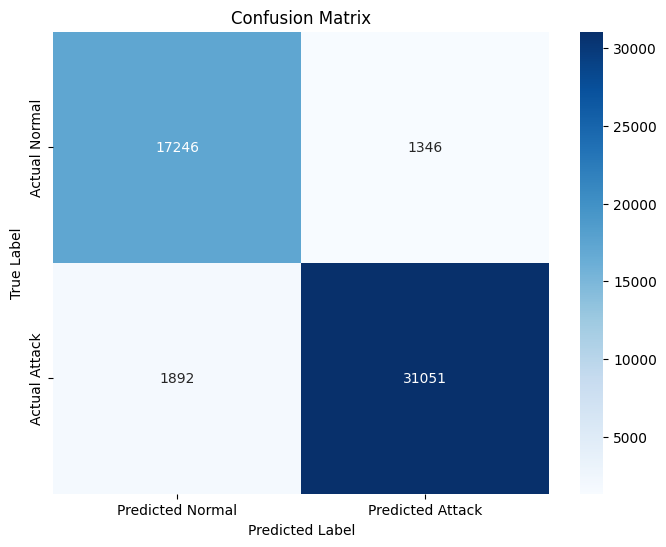

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions on test data
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    y_pred = test_outputs.argmax(dim=1).cpu().numpy()

# Convert true labels tensor to numpy array
y_true = y_test_tensor.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define labels for heatmap
xticklabels = ['Predicted Normal', 'Predicted Attack']
yticklabels = ['Actual Normal', 'Actual Attack']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Calculate false positives and false negatives from the test set confusion matrix
false_positives = cm[0, 1]  # Predicted 1, but actually 0
false_negatives = cm[1, 0]  # Predicted 0, but actually 1

# Calculate total actual positives and total actual negatives
total_positives = np.sum(cm[1, :])  # Total actual positives
total_negatives = np.sum(cm[0, :])  # Total actual negatives

# Calculate percentages
false_positive_rate = (false_positives / total_negatives) * 100
false_negative_rate = (false_negatives / total_positives) * 100

print("False Positive Rate:", false_positive_rate, "%")
print("False Negative Rate:", false_negative_rate, "%")


False Positive Rate: 7.239672977624785 %
False Negative Rate: 5.743253498467049 %


In [ ]:
#sample 10000 entries to make computation easier for fruitfly
sampled_df = df.sample(n=10000)

customFeatures = [0,4,10,22,23,26,36]#include 36 for label
custom_df = df.iloc[:,customFeatures]

In [ ]:
custom_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257673 entries, 0 to 175340
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   dur         257673 non-null  float64
 1   spkts       257673 non-null  int64  
 2   sload       257673 non-null  float64
 3   smean       257673 non-null  int64  
 4   dmean       257673 non-null  int64  
 5   ct_srv_src  257673 non-null  int64  
 6   label       257673 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 15.7 MB


In [ ]:
X = custom_df.drop(columns=['label'])
feature_list = list(X.columns)
X = np.array(X)
y = custom_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
y.shape


(257673,)

In [ ]:
print("Training set:", len(X_train))
print("Testing set:", len(X_test))

Training set: 206138
Testing set: 51535


In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.optim.lr_scheduler as lr_scheduler

# Check if GPU is available
if torch.cuda.is_available():
  device = torch.device("cuda")
elif torch.backends.mps.is_available():
  device = torch.device("mps")
else:
  device = torch.device("cpu")

print("Using device: ", device)
# Define your neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 15)
        self.fc4 = nn.Linear(15, 5)
        self.fc5 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Example usage
# Define input dimension
input_dim = X_train.shape[1]
batch_size = 64
epochs = 50

# Move the model to GPU
model = NeuralNetwork(input_dim).to(device)

# Convert your data to PyTorch tensors and move to GPU
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)


# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters())
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Define your dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Train your model
total_batches = len(train_loader)
# Define early stopping parameters
early_stopping_rounds = 5
best_val_loss = float('inf')
best_epoch = 0
early_stopping_counter = 0

# Train your model
for epoch in range(epochs):
    running_loss = 0.0
    val_loss = 0.0
    with tqdm(total=total_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss / (i+1)})
            pbar.update(1)

        # Calculate validation loss
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            val_loss = criterion(test_outputs, y_test_tensor)
            print(f"Train loss: {running_loss/(i+1)} Validation loss : {val_loss}")
            scheduler.step(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_rounds:
                print(f'Early stopping triggered! No improvement in validation loss for {early_stopping_rounds} consecutive epochs.')
                break

print('Training completed!')


Using device:  cuda


Epoch 1/50: 100%|██████████| 3221/3221 [00:17<00:00, 187.97batch/s, loss=0.316]


Train loss: 0.3157659174168343 Validation loss : 0.25233957171440125


Epoch 2/50: 100%|██████████| 3221/3221 [00:16<00:00, 190.72batch/s, loss=0.231]


Train loss: 0.23146938818261995 Validation loss : 0.22364327311515808


Epoch 3/50: 100%|██████████| 3221/3221 [00:17<00:00, 181.05batch/s, loss=0.212]


Train loss: 0.21226728019859434 Validation loss : 0.20672887563705444


Epoch 4/50: 100%|██████████| 3221/3221 [00:16<00:00, 193.97batch/s, loss=0.203]


Train loss: 0.2025605303804092 Validation loss : 0.2025330513715744


Epoch 5/50: 100%|██████████| 3221/3221 [00:16<00:00, 191.67batch/s, loss=0.196]


Train loss: 0.19556586029402998 Validation loss : 0.2007099986076355


Epoch 6/50: 100%|██████████| 3221/3221 [00:17<00:00, 187.51batch/s, loss=0.191]


Train loss: 0.1910568600944372 Validation loss : 0.19092032313346863


Epoch 7/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.46batch/s, loss=0.188]


Train loss: 0.18768525495084315 Validation loss : 0.18704438209533691


Epoch 8/50: 100%|██████████| 3221/3221 [00:17<00:00, 183.97batch/s, loss=0.184]


Train loss: 0.18366575432037463 Validation loss : 0.18391934037208557


Epoch 9/50: 100%|██████████| 3221/3221 [00:16<00:00, 193.82batch/s, loss=0.181]


Train loss: 0.1811847254386399 Validation loss : 0.17771126329898834


Epoch 10/50: 100%|██████████| 3221/3221 [00:16<00:00, 189.51batch/s, loss=0.178]


Train loss: 0.17779824600544306 Validation loss : 0.18612514436244965


Epoch 11/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.99batch/s, loss=0.176]


Train loss: 0.17631629860570475 Validation loss : 0.18206007778644562


Epoch 12/50: 100%|██████████| 3221/3221 [00:16<00:00, 189.94batch/s, loss=0.175]


Train loss: 0.17479473386550867 Validation loss : 0.1784670054912567


Epoch 13/50: 100%|██████████| 3221/3221 [00:17<00:00, 185.80batch/s, loss=0.173]


Train loss: 0.1728479094636788 Validation loss : 0.17747871577739716


Epoch 14/50: 100%|██████████| 3221/3221 [00:16<00:00, 191.18batch/s, loss=0.171]


Train loss: 0.17144153797082448 Validation loss : 0.17264746129512787


Epoch 15/50: 100%|██████████| 3221/3221 [00:16<00:00, 192.65batch/s, loss=0.17]


Train loss: 0.17020935087109973 Validation loss : 0.17503228783607483


Epoch 16/50: 100%|██████████| 3221/3221 [00:16<00:00, 192.94batch/s, loss=0.17]


Train loss: 0.16954688243140015 Validation loss : 0.17087027430534363


Epoch 17/50: 100%|██████████| 3221/3221 [00:16<00:00, 192.61batch/s, loss=0.168]


Train loss: 0.16766200413553287 Validation loss : 0.1733376681804657


Epoch 18/50: 100%|██████████| 3221/3221 [00:16<00:00, 190.40batch/s, loss=0.166]


Train loss: 0.1660533559753524 Validation loss : 0.1700286567211151


Epoch 19/50: 100%|██████████| 3221/3221 [00:17<00:00, 187.29batch/s, loss=0.165]


Train loss: 0.16489456204228503 Validation loss : 0.1680258959531784


Epoch 20/50: 100%|██████████| 3221/3221 [00:17<00:00, 179.98batch/s, loss=0.165]


Train loss: 0.16487851967466652 Validation loss : 0.17236235737800598


Epoch 21/50: 100%|██████████| 3221/3221 [00:16<00:00, 193.11batch/s, loss=0.164]


Train loss: 0.16368804686985858 Validation loss : 0.16679878532886505


Epoch 22/50: 100%|██████████| 3221/3221 [00:16<00:00, 192.28batch/s, loss=0.162]


Train loss: 0.16207953110610207 Validation loss : 0.1641765832901001


Epoch 23/50: 100%|██████████| 3221/3221 [00:16<00:00, 191.76batch/s, loss=0.161]


Train loss: 0.1611153950648153 Validation loss : 0.16154298186302185


Epoch 24/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.33batch/s, loss=0.16]


Train loss: 0.15986942814114263 Validation loss : 0.16223777830600739


Epoch 25/50: 100%|██████████| 3221/3221 [00:17<00:00, 183.79batch/s, loss=0.159]


Train loss: 0.15907196508814778 Validation loss : 0.16334867477416992


Epoch 26/50: 100%|██████████| 3221/3221 [00:17<00:00, 181.82batch/s, loss=0.159]


Train loss: 0.15907602893169512 Validation loss : 0.16307149827480316


Epoch 27/50: 100%|██████████| 3221/3221 [00:17<00:00, 182.38batch/s, loss=0.158]


Train loss: 0.15838088217321222 Validation loss : 0.1612682193517685


Epoch 28/50: 100%|██████████| 3221/3221 [00:17<00:00, 184.69batch/s, loss=0.158]


Train loss: 0.15781401035840542 Validation loss : 0.1620488166809082


Epoch 29/50: 100%|██████████| 3221/3221 [00:17<00:00, 185.98batch/s, loss=0.16]


Train loss: 0.15962158912287963 Validation loss : 0.1582670658826828


Epoch 30/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.74batch/s, loss=0.157]


Train loss: 0.15656789143745276 Validation loss : 0.16078247129917145


Epoch 31/50: 100%|██████████| 3221/3221 [00:17<00:00, 183.05batch/s, loss=0.157]


Train loss: 0.15728093478429656 Validation loss : 0.1666366308927536


Epoch 32/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.66batch/s, loss=0.156]


Train loss: 0.15646923903245172 Validation loss : 0.16151180863380432


Epoch 33/50: 100%|██████████| 3221/3221 [00:17<00:00, 183.89batch/s, loss=0.156]


Train loss: 0.1557130294139805 Validation loss : 0.17174451053142548


Epoch 34/50: 100%|██████████| 3221/3221 [00:17<00:00, 184.29batch/s, loss=0.152]


Train loss: 0.152427592198256 Validation loss : 0.1554742157459259


Epoch 35/50: 100%|██████████| 3221/3221 [00:17<00:00, 185.16batch/s, loss=0.15]


Train loss: 0.15040614129267044 Validation loss : 0.1588248461484909


Epoch 36/50: 100%|██████████| 3221/3221 [00:17<00:00, 188.10batch/s, loss=0.15]


Train loss: 0.15027473459829274 Validation loss : 0.1559387892484665


Epoch 37/50: 100%|██████████| 3221/3221 [00:17<00:00, 188.21batch/s, loss=0.15]


Train loss: 0.1502251433907149 Validation loss : 0.1560470163822174


Epoch 38/50: 100%|██████████| 3221/3221 [00:17<00:00, 187.45batch/s, loss=0.15]


Train loss: 0.14969736382883367 Validation loss : 0.15795719623565674


Epoch 39/50: 100%|██████████| 3221/3221 [00:16<00:00, 189.79batch/s, loss=0.147]

Train loss: 0.14740923103043396 Validation loss : 0.15561024844646454
Early stopping triggered! No improvement in validation loss for 5 consecutive epochs.
Training completed!


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted_labels = torch.max(test_outputs, 1)
    predicted_labels = predicted_labels.cpu().numpy()
    y_test_numpy = y_test_tensor.cpu().numpy()

accuracy = accuracy_score(y_test_numpy, predicted_labels)
precision = precision_score(y_test_numpy, predicted_labels, average='weighted')
recall = recall_score(y_test_numpy, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9220141651304938
Precision: 0.9219194851693899
Recall: 0.9220141651304938


# fruitfly feature extraction algorithm


In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



# Define parameters for FFOA
num_fruit_flies = 50
num_generations = 100
max_features = X_train.shape[1]

# Define fitness function
def fitness(features):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train[:, features], y_train)
    y_pred = clf.predict(X_test[:, features])
    return accuracy_score(y_test, y_pred)

population = np.random.randint(0, 2, size=(num_fruit_flies, max_features), dtype=bool)


for generation in range(num_generations):
    fitness_scores = np.array([fitness(features) for features in population])
    elite_flies = population[np.argsort(fitness_scores)][-10:]
    new_population = []
    for _ in range(num_fruit_flies):
        parents = elite_flies[np.random.choice(elite_flies.shape[0], size=2)]
        crossover_point = np.random.randint(0, max_features)
        child = np.hstack((parents[0, :crossover_point], parents[1, crossover_point:]))
        mutation_rate = 0.1
        mutation_mask = np.random.rand(max_features) < mutation_rate
        child[mutation_mask] = ~child[mutation_mask]
        new_population.append(child)
    population = np.array(new_population)


best_fruit_fly = elite_flies[-1]


selected_features = np.where(best_fruit_fly)[0]
print("Selected Features:", selected_features)

Selected Features: [ 4  6  8 11 16 17 18 19 23 24 25 26 27 29 31 32 33 35]


# Information Gain Feature Extraction

In [18]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

information_gain = mutual_info_classif(X_train, y_train)

num_selected_features = 5
selected_features_indices = information_gain.argsort()[-num_selected_features:]
selected_features = X_train[:, selected_features_indices]


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(selected_features, y_train)

X_test_selected = X_test[:, selected_features_indices]
y_pred = clf.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Selected Features Indices:", selected_features_indices)

Accuracy: 0.9237799553701368
Selected Features Indices: [ 8 27 22 10  6]


In [19]:
X_train_infogain = X_train[:, selected_features_indices]
X_test_infogain = X_test[:, selected_features_indices]

In [20]:
print(X_train_infogain.shape[1])

5


In [21]:
# Define input dimension based on the number of selected features
input_dim_infogain = X_train_infogain.shape[1]
batch_size = 64
epochs = 50

# Standardize the selected features
scaler = StandardScaler()
X_train_infogain = scaler.fit_transform(X_train_infogain)
X_test_infogain = scaler.transform(X_test_infogain)


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert your data to PyTorch tensors and move to GPU
X_train_tensor_infogain = torch.FloatTensor(X_train_infogain).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
X_test_tensor_infogain = torch.FloatTensor(X_test_infogain).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)

# Move the model to GPU
model_selected = NeuralNetwork(input_dim_infogain).to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_selected.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Define your dataloaders
train_dataset_infogain = TensorDataset(X_train_tensor_infogain, y_train_tensor)
train_loader_infogain = DataLoader(train_dataset_infogain, batch_size=batch_size, shuffle=True)

# Train your model
from tqdm import tqdm

# Train your model
total_batches = len(train_loader_infogain)
# Define early stopping parameters
early_stopping_rounds = 5
best_val_loss = float('inf')
best_epoch = 0
early_stopping_counter = 0

# Train your model
for epoch in range(epochs):
    running_loss = 0.0
    val_loss = 0.0
    with tqdm(total=total_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for i, (inputs, targets) in enumerate(train_loader_infogain):
            optimizer.zero_grad()
            outputs = model_selected(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss / (i+1)})
            pbar.update(1)

        # Calculate validation loss
        with torch.no_grad():
            test_outputs = model_selected(X_test_tensor_infogain)
            val_loss = criterion(test_outputs, y_test_tensor)
            print(f"Train loss: {running_loss/(i+1)} Validation loss : {val_loss}")
            scheduler.step(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_rounds:
                print(f'Early stopping triggered! No improvement in validation loss for {early_stopping_rounds} consecutive epochs.')
                break

print('Training completed!')


# Evaluate your model
with torch.no_grad():
    train_outputs = model_selected(X_train_tensor_infogain)
    train_loss = criterion(train_outputs, y_train_tensor)
    train_acc = (train_outputs.argmax(dim=1) == y_train_tensor).float().mean()

    test_outputs = model_selected(X_test_tensor_infogain)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_acc = (test_outputs.argmax(dim=1) == y_test_tensor).float().mean()

print(f'Train: Loss: {train_loss.item()}, Accuracy: {train_acc.item()}')
print(f'Validation: Loss: {test_loss.item()}, Accuracy: {test_acc.item()}')
print(f'Best Validation Loss: {best_val_loss.item()} at Epoch {best_epoch+1}')


Epoch 1/50: 100%|██████████| 3221/3221 [00:17<00:00, 182.64batch/s, loss=0.403]


Train loss: 0.40305328258573175 Validation loss : 0.36890357732772827


Epoch 2/50: 100%|██████████| 3221/3221 [00:17<00:00, 188.24batch/s, loss=0.368]


Train loss: 0.36814419233588025 Validation loss : 0.36890071630477905


Epoch 3/50: 100%|██████████| 3221/3221 [00:18<00:00, 177.16batch/s, loss=0.368]


Train loss: 0.3681615779337695 Validation loss : 0.36890077590942383


Epoch 4/50: 100%|██████████| 3221/3221 [00:17<00:00, 184.30batch/s, loss=0.275]


Train loss: 0.2749876458751826 Validation loss : 0.24753618240356445


Epoch 5/50: 100%|██████████| 3221/3221 [00:17<00:00, 179.18batch/s, loss=0.241]


Train loss: 0.24136167900212913 Validation loss : 0.23892943561077118


Epoch 6/50: 100%|██████████| 3221/3221 [00:16<00:00, 190.69batch/s, loss=0.233]


Train loss: 0.23286411326490772 Validation loss : 0.2338034063577652


Epoch 7/50: 100%|██████████| 3221/3221 [00:17<00:00, 187.30batch/s, loss=0.228]


Train loss: 0.22843997650142228 Validation loss : 0.2291201502084732


Epoch 8/50: 100%|██████████| 3221/3221 [00:17<00:00, 183.08batch/s, loss=0.227]


Train loss: 0.22672432374691454 Validation loss : 0.2273779958486557


Epoch 9/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.23batch/s, loss=0.224]


Train loss: 0.22371728907031918 Validation loss : 0.20440125465393066


Epoch 10/50: 100%|██████████| 3221/3221 [00:16<00:00, 189.79batch/s, loss=0.198]


Train loss: 0.19757970852285245 Validation loss : 0.19489583373069763


Epoch 11/50: 100%|██████████| 3221/3221 [00:17<00:00, 188.04batch/s, loss=0.192]


Train loss: 0.19213284510808012 Validation loss : 0.19730480015277863


Epoch 12/50: 100%|██████████| 3221/3221 [00:17<00:00, 188.67batch/s, loss=0.191]


Train loss: 0.19144133842373554 Validation loss : 0.19354695081710815


Epoch 13/50: 100%|██████████| 3221/3221 [00:17<00:00, 187.87batch/s, loss=0.191]


Train loss: 0.19064181912268255 Validation loss : 0.189993754029274


Epoch 14/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.09batch/s, loss=0.19]


Train loss: 0.189973410372777 Validation loss : 0.1915041208267212


Epoch 15/50: 100%|██████████| 3221/3221 [00:17<00:00, 185.04batch/s, loss=0.19]


Train loss: 0.1896303256580971 Validation loss : 0.1911936104297638


Epoch 16/50: 100%|██████████| 3221/3221 [00:17<00:00, 189.07batch/s, loss=0.189]


Train loss: 0.18948549156310543 Validation loss : 0.1911797672510147


Epoch 17/50: 100%|██████████| 3221/3221 [00:16<00:00, 189.50batch/s, loss=0.189]


Train loss: 0.1890304663543263 Validation loss : 0.1903887689113617


Epoch 18/50: 100%|██████████| 3221/3221 [00:17<00:00, 188.96batch/s, loss=0.187]


Train loss: 0.1867472675577782 Validation loss : 0.18845514953136444


Epoch 19/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.81batch/s, loss=0.187]


Train loss: 0.18661022327726984 Validation loss : 0.18915945291519165


Epoch 20/50: 100%|██████████| 3221/3221 [00:17<00:00, 187.14batch/s, loss=0.186]


Train loss: 0.18621067305837719 Validation loss : 0.19012480974197388


Epoch 21/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.77batch/s, loss=0.186]


Train loss: 0.1862643613476851 Validation loss : 0.18860416114330292


Epoch 22/50: 100%|██████████| 3221/3221 [00:17<00:00, 185.95batch/s, loss=0.186]


Train loss: 0.18608057295839375 Validation loss : 0.1888681948184967


Epoch 23/50: 100%|██████████| 3221/3221 [00:17<00:00, 188.99batch/s, loss=0.185]


Train loss: 0.1848586010730755 Validation loss : 0.18646715581417084


Epoch 24/50: 100%|██████████| 3221/3221 [00:17<00:00, 188.03batch/s, loss=0.185]


Train loss: 0.18481890221109898 Validation loss : 0.18778082728385925


Epoch 25/50: 100%|██████████| 3221/3221 [00:17<00:00, 187.26batch/s, loss=0.185]


Train loss: 0.18474581392492911 Validation loss : 0.1865851879119873


Epoch 26/50: 100%|██████████| 3221/3221 [00:17<00:00, 187.78batch/s, loss=0.185]


Train loss: 0.18468079246518146 Validation loss : 0.18657909333705902


Epoch 27/50: 100%|██████████| 3221/3221 [00:17<00:00, 185.84batch/s, loss=0.185]


Train loss: 0.18452289409516798 Validation loss : 0.1874767541885376


Epoch 28/50: 100%|██████████| 3221/3221 [00:17<00:00, 184.57batch/s, loss=0.184]


Train loss: 0.18386384239666065 Validation loss : 0.18608202040195465


Epoch 29/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.59batch/s, loss=0.184]


Train loss: 0.18367332655523586 Validation loss : 0.18602648377418518


Epoch 30/50: 100%|██████████| 3221/3221 [00:17<00:00, 188.26batch/s, loss=0.184]


Train loss: 0.18364975226476896 Validation loss : 0.18574753403663635


Epoch 31/50: 100%|██████████| 3221/3221 [00:17<00:00, 188.54batch/s, loss=0.184]


Train loss: 0.18365763532022666 Validation loss : 0.18571056425571442


Epoch 32/50: 100%|██████████| 3221/3221 [00:17<00:00, 187.63batch/s, loss=0.184]


Train loss: 0.1836084677533902 Validation loss : 0.1857173889875412


Epoch 33/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.79batch/s, loss=0.184]


Train loss: 0.18356105383833682 Validation loss : 0.18629683554172516


Epoch 34/50: 100%|██████████| 3221/3221 [00:17<00:00, 188.11batch/s, loss=0.184]


Train loss: 0.1835612663603077 Validation loss : 0.18579484522342682


Epoch 35/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.85batch/s, loss=0.184]


Train loss: 0.18355521335804623 Validation loss : 0.1856098771095276


Epoch 36/50: 100%|██████████| 3221/3221 [00:17<00:00, 183.65batch/s, loss=0.183]


Train loss: 0.18348331408947013 Validation loss : 0.18583619594573975


Epoch 37/50: 100%|██████████| 3221/3221 [00:17<00:00, 184.39batch/s, loss=0.183]


Train loss: 0.18346070086954175 Validation loss : 0.1859636753797531


Epoch 38/50: 100%|██████████| 3221/3221 [00:17<00:00, 184.61batch/s, loss=0.183]


Train loss: 0.1834266509135589 Validation loss : 0.1854843944311142


Epoch 39/50: 100%|██████████| 3221/3221 [00:17<00:00, 185.90batch/s, loss=0.183]


Train loss: 0.18336886643220718 Validation loss : 0.18538297712802887


Epoch 40/50: 100%|██████████| 3221/3221 [00:17<00:00, 185.75batch/s, loss=0.183]


Train loss: 0.18340364694063319 Validation loss : 0.18577030301094055


Epoch 41/50: 100%|██████████| 3221/3221 [00:17<00:00, 187.77batch/s, loss=0.183]


Train loss: 0.18325942719817273 Validation loss : 0.1854783147573471


Epoch 42/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.83batch/s, loss=0.183]


Train loss: 0.1833153778096694 Validation loss : 0.1852477341890335


Epoch 43/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.18batch/s, loss=0.183]


Train loss: 0.183333888759814 Validation loss : 0.1862516850233078


Epoch 44/50: 100%|██████████| 3221/3221 [00:17<00:00, 185.99batch/s, loss=0.183]


Train loss: 0.18317308372944288 Validation loss : 0.1854468584060669


Epoch 45/50: 100%|██████████| 3221/3221 [00:17<00:00, 184.48batch/s, loss=0.183]


Train loss: 0.18318027493626907 Validation loss : 0.18621592223644257


Epoch 46/50: 100%|██████████| 3221/3221 [00:17<00:00, 184.37batch/s, loss=0.183]


Train loss: 0.18315978562913302 Validation loss : 0.1854533851146698


Epoch 47/50: 100%|██████████| 3221/3221 [00:17<00:00, 184.77batch/s, loss=0.183]


Train loss: 0.1827716043150155 Validation loss : 0.18502666056156158


Epoch 48/50: 100%|██████████| 3221/3221 [00:17<00:00, 187.16batch/s, loss=0.183]


Train loss: 0.18272595425610288 Validation loss : 0.1850091964006424


Epoch 49/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.59batch/s, loss=0.183]


Train loss: 0.18271634479864937 Validation loss : 0.18549108505249023


Epoch 50/50: 100%|██████████| 3221/3221 [00:17<00:00, 184.76batch/s, loss=0.183]


Train loss: 0.182726612175216 Validation loss : 0.18523278832435608
Training completed!
Train: Loss: 0.18261350691318512, Accuracy: 0.902482807636261
Validation: Loss: 0.18523278832435608, Accuracy: 0.9007664322853088
Best Validation Loss: 0.1850091964006424 at Epoch 48
